In [29]:
# %load classify.py
import numpy as np
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
from svector import svector
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB


#trainfile = sys.argv[1]
#devfile = sys.argv[2]
#testfile = sys.argv[3]

trainfile = "train.txt"
devfile = "dev.txt"
testfile = "test.txt"

output = {}


def parse_from(textfile):
    for line in open(textfile):
        label, words = line.strip().split("\t")
        yield (1 if label=="+" else -1, words)

def read_from(textfile):
    for line in open(textfile):
        label, words = line.strip().split("\t")
        yield (1 if label=="+" else -1, words.split())


def preprocess(file):
    x_out = []
    y_out = []

    for i, (label, words) in enumerate(parse_from(file), 1):
        x_out.append(words)
        y_out.append(label)

    return (x_out, y_out)



def make_vector(words):
    v = svector()
    v['im_bias'] = 1   # add a bias feature, set it to 1, we now have d+1 dim
    for word in words:
        v[word] += 1
    return v
   

def test(devfile, model, dev_errs):
    tot, err = 0, 0
    for i, (label, words) in enumerate(read_from(devfile), 1): # note 1...|D|
        err += label * (model.dot(make_vector(words))) <= 0
        # get max/min errors on dev
        dev_errs.append((label, label * (model.dot(make_vector(words))), words))
    return err/i  # i is |D| now
           

def train(trainfile, devfile, epochs=5):
    t = time.time()
    best_err = 1.
    model = svector()
    model['im_bias'] = 0  # add a bias weight, set it to 0, we now have d+1 dim
    for it in range(1, epochs+1):
        updates = 0
        for i, (label, words) in enumerate(read_from(trainfile), 1): # label is +1 or -1
            sent = make_vector(words)
            if label * (model.dot(sent)) <= 0:
                updates += 1
                model += label * sent  
        dev_errs = []
        dev_err = test(devfile, model, dev_errs)
        best_err = min(best_err, dev_err)
        #print("epoch %d, update %.1f%%, dev %.1f%%" % (it, updates / i * 100, dev_err * 100))
    #print("best dev err %.1f%%, |w|=%d, time: %.1f secs" % (best_err * 100, len(model), time.time() - t))



def train_avg(trainfile, devfile, epochs=5):
    t = time.time()
    best_err = 1.
    model = svector()
    model['im_bias'] = 0  # add a bias weight, set it to 0, we now have d+1 dim
    w_aux = svector()
    count = 0
    #print() 
    for it in range(1, epochs+1):
        updates = 0
        for i, (label, words) in enumerate(read_from(trainfile), 1): # label is +1 or -1
            sent = make_vector(words)
            if label * (model.dot(sent)) <= 0:  # model made a mistake
                updates += 1
                model += label * sent
                w_aux += count * label * sent
            count += 1 
        dev_errs = []
        dev_err = test(devfile, (count * model) - w_aux, dev_errs)
        best_err = min(best_err, dev_err)


    # print("Avg Perceptron Dev Error: %.1f%%, |w|: %d, time: %.1f secs" % (best_err * 100, len(model), time.time() - t))
    output["avg"] = [best_err*100, 0]

    return model


# predict on test data
def predict(testfile, model): 
    y_test_pred = []
    t = time.time()
    for i, (label, words) in enumerate(read_from(testfile), 1):
        pred = (model.dot(make_vector(words)))
        y_test_pred.append(1 if pred > 0 else -1)
    y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
    #print(f"Avg Perceptron % Pos on Test data: {100*y_test_tot/1000:.1f}%")
    #print()
    output["avg"][1] = 100*y_test_tot/1000



model = train_avg(trainfile, devfile, 10)
predict(testfile, model)


#######################################################
#######################################################


# pre-process the data into TF-IDF form
x_train, y_train = preprocess(trainfile)
x_dev, y_dev = preprocess(devfile)


vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_dev = vectorizer.transform(x_dev)

x_test, y_test = preprocess(testfile)
x_test = vectorizer.transform(x_test)



# run an SVM classifier
svc = SVC(kernel='linear')
t_svc = time.time()
svc.fit(x_train, y_train)
y_dev_pred = svc.predict(x_dev)
svc_acc = accuracy_score(y_dev, y_dev_pred)
#print(f"SVC Classifier Dev Error: {100-100*svc_acc:.1f}%, |w|: {len(vectorizer.get_feature_names_out())}, time: {(time.time() - t_svc):.1f} secs")
output["svm"] = [100-100*svc_acc, 0]

y_test_pred = svc.predict(x_test)
y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
#print(f"SVC % Pos on Test data: {100*y_test_tot/1000:.1f}%")
#print()
output["svm"][1] = 100*y_test_tot/1000


# run an MNB classifier
mnb = MultinomialNB()
t_mnb = time.time()
mnb.fit(x_train, y_train)
y_dev_pred = mnb.predict(x_dev)
mnb_acc = accuracy_score(y_dev, y_dev_pred)
#print(f"MNB Classifier Dev Error: {100-100*mnb_acc:.1f}%, |w|: {len(vectorizer.get_feature_names_out())}, time: {(time.time() - t_mnb):.1f} secs")
output["mnb"] = [100-100*mnb_acc, 0]

y_test_pred = mnb.predict(x_test)
y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
#print(f"MNB % Pos on Test data: {100*y_test_tot/1000:.1f}%")
#print()
output["mnb"][1] = 100*y_test_tot/1000


# run an MLP classifier
mlp = MLPClassifier()
t_mlp = time.time()
mlp.fit(x_train, y_train)
y_dev_pred = mlp.predict(x_dev)
mlp_acc = accuracy_score(y_dev, y_dev_pred)
#print(f"MLP Classifier Dev Error: {100-100*mlp_acc:.1f}%, |w|: {len(vectorizer.get_feature_names_out())}, time: {(time.time() - t_mlp):.1f} secs")
output["mlp"] = [100-100*mlp_acc, 0]

y_test_pred = mlp.predict(x_test)
y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
#print(f"MLP % Pos on Test data: {100*y_test_tot/1000:.1f}%")
#print()
output["mlp"][1] = 100*y_test_tot/1000

for k,v in output.items():
    print(f"{k},{v[0]:.1f},{v[1]:.1f}")



avg,26.3,40.2
svm,26.8,47.8
mnb,23.0,48.6
mlp,27.5,50.2


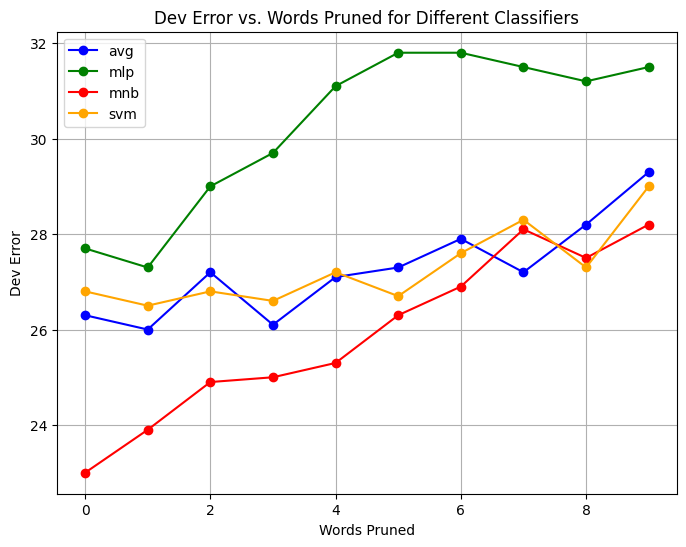

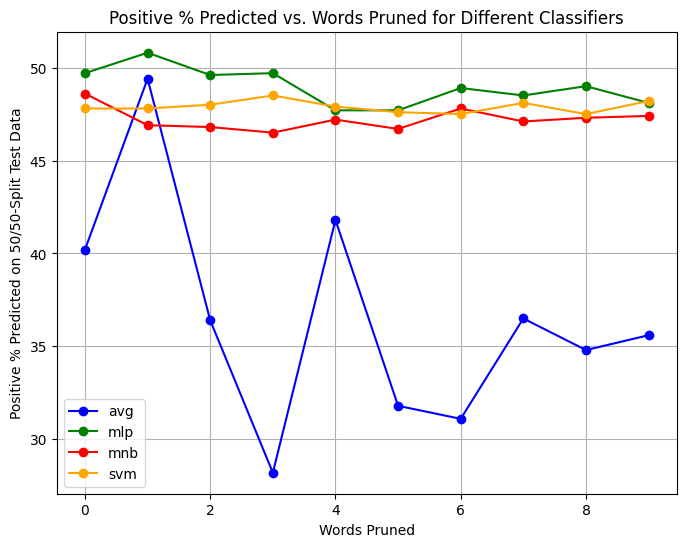

In [31]:
## after running tasks-graph.sh
## use resulting csv file "graph.csv" to plot classification results

df = pd.read_csv('graph.csv', names=["classifier","dev","pos","prune"])

classifier = df['classifier']
dev_err = df['dev']
percent_pos = df['pos']
words_pruned = df['prune']


# group each of the classifiers by classifier name
grouped = df.groupby('classifier')


# Create a figure and axis for Dev_Error plots
fig1, ax1 = plt.subplots(figsize=(8, 6))

# Define colors and markers for each group
colors = ['blue', 'green', 'red', 'orange']

# Iterate through groups and plot lines for each group
for i, (label, group) in enumerate(grouped):
    ax1.plot(group['prune'], group['dev'], label=label, color=colors[i], marker='o', linestyle='-')

# Set labels and title
ax1.set_xlabel('Words Pruned')
ax1.set_ylabel('Dev Error')
ax1.set_title('Dev Error vs. Words Pruned for Different Classifiers')

# Show legend
ax1.legend()

# Show the plot
plt.grid(True)
plt.show()






# Create another figure and axis for Percent_Pos plots
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Define colors and markers for each group
colors = ['blue', 'green', 'red', 'orange']

# Iterate through groups and plot lines for each group
for i, (label, group) in enumerate(grouped):
    ax2.plot(group['prune'], group['pos'], label=label, color=colors[i], marker='o', linestyle='-')

# Set labels and title
ax2.set_xlabel('Words Pruned')
ax2.set_ylabel('Positive % Predicted on 50/50-Split Test Data')
ax2.set_title('Positive % Predicted vs. Words Pruned for Different Classifiers')

# Show legend
ax2.legend()

# Show the plot
plt.grid(True)
plt.show()